In [1]:
%pylab inline
import numpy as np 
import pandas as pd
import seaborn as sns
import string

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Data Preprocessing

- 약 13.5% 만이 spam으로 분류되어 있다. 즉 class imbalance 문제가 있다.
- unique 메세지를 보면 duplicate text가 존재함을 알 수 있다.

In [2]:
data = pd.read_csv('spam.csv', encoding='latin-1', usecols=(0, 1), names=('class', 'text'), skiprows=1)
display(data.head())
display(data.groupby('class').describe())

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


text                                                               
      count unique                                                top freq
class                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

아래의 histogram에서 알 수 있듯이, 대부분의 Ham의 글자길이는 대부분 100이하에 있고, Spam의 경우는 150쯤에 있습니다.<br>
즉 길이의 차이가 있으며, Spam이 문장의 길이가 더 깁니다.

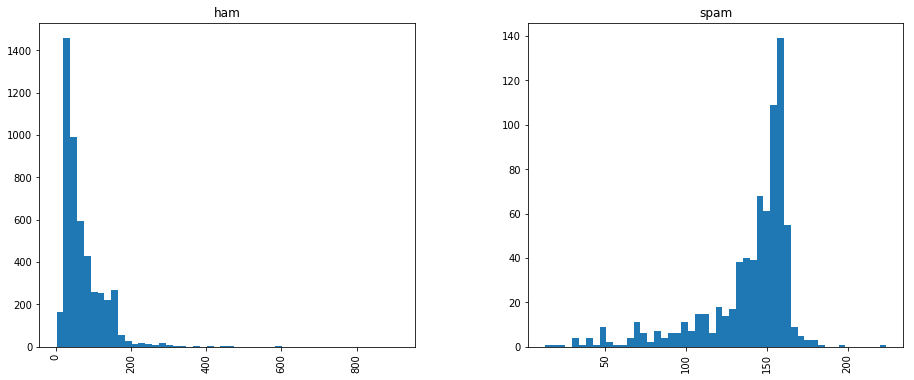

In [3]:
data['length'] = data['text'].apply(len)
ax = data.hist('length', by='class', bins=50, figsize=(15, 6))

# Tokenizing

process_text는 먼저 문장속에서 !,\` 같은 punctuation을 삭제합니다.<br>
이후 stopwords를 삭제시킵니다.

Stopwords란 `a`, `the`, `of`, `at` 처럼 빈번하게 사용되는 단어들을 가르킵니다.><br>
Word frequency를 이용한 확률적 모델에는 이런 비번하게 사용되는 단어들에 특별한 의미가 없기 때문에 제거를 합니다.

In [4]:
def process_text(text):
    
    # Remove Punctuations
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    # Remove stopwords
    cleaned_words = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    return cleaned_words

data['text'].apply(process_text).head()

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: text, dtype: object

# Model

In [5]:
pipeline = Pipeline([
    ('vectorization', CountVectorizer(analyzer=process_text)),  # Convert strings to frequency vectors
    ('tfidf', TfidfTransformer()),  # Convert vectors to weighted TF-IDF scores
    ('classifier', MultinomialNB())
])

# Train

In [6]:
train_x, test_x, train_y, test_y = train_test_split(data['text'], data['class'], test_size=0.2)

print('[X]')
display(train_x.head())

print('\n[Y]')
display(train_y.head())

[X]


2713    Nope i'm not drivin... I neva develop da photo...
995       Change again... It's e one next to escalator...
615     \Happy valentines day\" I know its early but i...
1189    In that case I guess I'll see you at campus lodge
178     Text her. If she doesnt reply let me know so i...
Name: text, dtype: object


[Y]


2713    ham
995     ham
615     ham
1189    ham
178     ham
Name: class, dtype: object

In [7]:
pipeline.fit(train_x, train_y)

Pipeline(memory=None,
     steps=[('vectorization', CountVectorizer(analyzer=<function process_text at 0x7f308a1feea0>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), prepr...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

# Predict

             precision    recall  f1-score   support

        ham       0.96      1.00      0.98       963
       spam       1.00      0.75      0.86       152

avg / total       0.97      0.97      0.96      1115



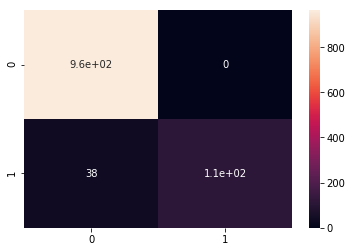

In [8]:
pred_y = pipeline.predict(test_x)

print(classification_report(test_y, pred_y))
sns.heatmap(confusion_matrix(test_y, pred_y), annot=True)